In [1]:
# Install libAUC and medMNIST
!pip install libauc==1.2.0
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [3]:
## loading PneumoniaMNIST dataset

#data_flag = 'pathmnist'
data_flag = 'pneumoniamnist'
download = True

#NUM_EPOCHS = 3
BATCH_SIZE = 64
#lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# transformer definitions -- go here
# default transformer


## transfomer to experiment --  
# the below is data --augmentation -- transformer
transform_train = transforms.Compose([
#   transforms.RandomHorizontalFlip(),
#   transforms.RandomRotation(degrees=10),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# load the data
train_dataset = DataClass(split='train', transform=transform_train, download=download)
test_dataset = DataClass(split='test', transform=transform_test, download=download)
val_dataset = DataClass(split='val', transform=transform_val, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)



Using downloaded and verified file: /Users/sreeshreddy/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/sreeshreddy/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/sreeshreddy/.medmnist/pneumoniamnist.npz


In [5]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /Users/sreeshreddy/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: /Users/sreeshreddy/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 

In [6]:
from torchvision.models import Weights
# instantiate the ResNet-50 model and set it to training mode
# model = ResNet50() --> yielded  low AUC and ACC on train and test data.
# instantiate the ResNet-18 model[Single Channel] and set it to training mode --
# added dropout and batch normalization as regularization methods.
import torchvision
model = torchvision.models.resnet18()
# model = model.cuda()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)



from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 10
decay_epochs = [25, 50, 75]

# Set new hyperparameters
lr = 0.1  # Lower learning rate
weight_decay = 0.01  # Decrease weight decay
margin = 1.0
loss_fn = AUCMLoss()

# Set optimizer with new hyperparameters
optimizer = PESG(model, 
                 loss_fn=loss_fn, 
                 momentum=0.8,
                 margin=margin,
                 epoch_deacy = 0.03,
                 lr=lr)


In [7]:
from sklearn.metrics import roc_auc_score

from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score


print('Training initiated')
print('*' * 15)

train_log = []
val_log = []
test_log = []
best_val_auc = 0
patience = 15
num_epochs_without_improvement = 0
for epoch in range(total_epochs):

    train_loss = []
    model.train()
    for data, targets in tqdm(train_loader):
        y_pred = model(data)
        loss = loss_fn(y_pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # evaluation on train, validation, and test sets
    model.eval()
    train_pred_list = []
    train_true_list = []
    for train_data, train_targets in train_loader_at_eval:
        train_pred = model(train_data)
        train_pred_list.append(train_pred.cpu().detach().numpy())
        train_true_list.append(train_targets.numpy())
    train_true = np.concatenate(train_true_list)
    train_pred = np.concatenate(train_pred_list)
    train_auc = auc_roc_score(train_true, train_pred)
    train_loss = np.mean(train_loss)

    val_pred_list = []
    val_true_list = []
    for val_data, val_targets in val_loader:
        val_pred = model(val_data)
        val_pred_list.append(val_pred.cpu().detach().numpy())
        val_true_list.append(val_targets.numpy())
    val_true = np.concatenate(val_true_list)
    val_pred = np.concatenate(val_pred_list)
    val_auc = auc_roc_score(val_true, val_pred)

    test_pred_list = []
    test_true_list = []
    for test_data, test_targets in test_loader:
        test_pred = model(test_data)
        test_pred_list.append(test_pred.cpu().detach().numpy())
        test_true_list.append(test_targets.numpy())
    test_true = np.concatenate(test_true_list)
    test_pred = np.concatenate(test_pred_list)
    test_auc = auc_roc_score(test_true, test_pred)
    model.train()

    # print results
    print("At epoch: %s, the train_loss: %.4f, the train_auc: %.4f, the val_auc: %.4f, the test_auc: %.4f, lr: %.4f" % (
        epoch, train_loss, train_auc[0], val_auc[0], test_auc[0], optimizer.lr))
    train_log.append(train_auc[0])
    val_log.append(val_auc[0])
    test_log.append(test_auc[0])

    # check for improvement in validation AUC and update early stopping counter
    if val_auc[0] > best_val_auc:
        best_val_auc = val_auc[0]
        best_test_auc = test_auc[0]
        torch.save(model, 'saved_model/best-model-Pn1.pt')
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1

    # check if early stopping criteria is met
    if num_epochs_without_improvement >= patience:
        print(f'No improvement for {patience} epochs. Stopping early.')
        break


Training initiated
***************


100%|███████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


At epoch: 0, the train_loss: 4.5557, the train_auc: 0.9473, the val_auc: 0.9365, the test_auc: 0.9099, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:35<00:00,  2.06it/s]


At epoch: 1, the train_loss: 0.0526, the train_auc: 0.9644, the val_auc: 0.9655, the test_auc: 0.9215, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:34<00:00,  2.13it/s]


At epoch: 2, the train_loss: 0.0398, the train_auc: 0.9765, the val_auc: 0.9754, the test_auc: 0.9256, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:34<00:00,  2.12it/s]


At epoch: 3, the train_loss: 0.0336, the train_auc: 0.9791, the val_auc: 0.9762, the test_auc: 0.9246, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:35<00:00,  2.08it/s]


At epoch: 4, the train_loss: 0.0322, the train_auc: 0.9537, the val_auc: 0.9577, the test_auc: 0.9079, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:38<00:00,  1.92it/s]


At epoch: 5, the train_loss: 0.0270, the train_auc: 0.9859, the val_auc: 0.9851, the test_auc: 0.9232, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:37<00:00,  1.95it/s]


At epoch: 6, the train_loss: 0.0244, the train_auc: 0.9877, the val_auc: 0.9884, the test_auc: 0.9267, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:46<00:00,  1.58it/s]


At epoch: 7, the train_loss: 0.0217, the train_auc: 0.9880, the val_auc: 0.9880, the test_auc: 0.9245, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:44<00:00,  1.67it/s]


At epoch: 8, the train_loss: 0.0193, the train_auc: 0.9876, the val_auc: 0.9871, the test_auc: 0.9255, lr: 0.1000


100%|███████████████████████████████████████████| 74/74 [00:40<00:00,  1.82it/s]


At epoch: 9, the train_loss: 0.0191, the train_auc: 0.9912, the val_auc: 0.9911, the test_auc: 0.9216, lr: 0.1000


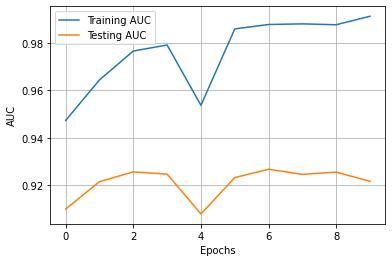

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(test_log, label='Testing AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid()
plt.show()


In [9]:
print("The Final Train AUC:", train_log[-1])
print("The Final Test AUC:", test_log[-1])


The Final Train AUC: 0.991201909793112
The Final Test AUC: 0.9215976331360947


In [10]:
print("The best test auc obtained for the PneumoniaMNIST dataset is:", best_test_auc)

The best test auc obtained for the PneumoniaMNIST dataset is: 0.9215976331360947
